# Final Computer vision Project
## Action Recognition Using Xception+LSTM & Two Stream Techniques
### Contributers: Mostafa Hegazy & Mohamed Ahmed

#### Install the necessary modules & Libraries

In [ ]:
!pip install keras-video-generators
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF11 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

#### Helper Functions for fetching the UCF11 or UCF101 dataset 

In [ ]:
# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(240, 240)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')


### Spatial Model 

#### Load the UCF11 RGB Dataset from the google drive

In [ ]:
!wget  --no-check-certificate -r\
 'https://docs.google.com/uc?export=download&id=1W46sQKbcMQF3SKfQDm0Cd7jm90ap_yic' -O 'DatasetV2'

In [ ]:
# Unzip the UCF11 dataset into 1 folder with 2 subfolders train and test
!unzip DatasetV2

#### Getting the class names from the folders 

In [ ]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = [i.split(os.path.sep)[3] for i in glob.glob('./DataSetV2/train/*')]
classes.sort()

In [ ]:
classes

['basketball',
 'biking',
 'diving',
 'golf_swing',
 'horse_riding',
 'soccer_juggling',
 'swing',
 'tennis_swing',
 'trampoline_jumping',
 'volleyball_spiking',
 'walking']

In [ ]:
#@title Make all the files in 1 subfolder for each class
# import shutil

# for Class in classes:
#   subfolder = [j.split(os.path.sep)[4] for j in glob.glob(f'/content/UCF11_updated_mpg/{Class}/*')]
#   subfolder.sort()
#   for i in range(1,26):
#     folder = [j for j in glob.glob(f'/content/UCF11_updated_mpg/{Class}/{subfolder[i]}/*')]
#     if subfolder[i-1][0] == 'v':
#       for File in folder:
#         dst = f'/content/UCF11_updated_mpg/{Class}/'
#         shutil.move(File, dst)
#shutil.make_archive('DatasetV2', 'zip', 'UCF11_updated_mpg')

#### Initializing the data generator

In [ ]:
SIZE = (240, 240)
CHANNELS = 3
NBFRAME = 5 
BS = 8
# pattern to get videos and classes
glob_pattern= './DataSetV2/train/{classname}/*.mpg'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip= True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.1, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

In [ ]:
valid = train.get_validation_generator()

#### Show RGB Examples

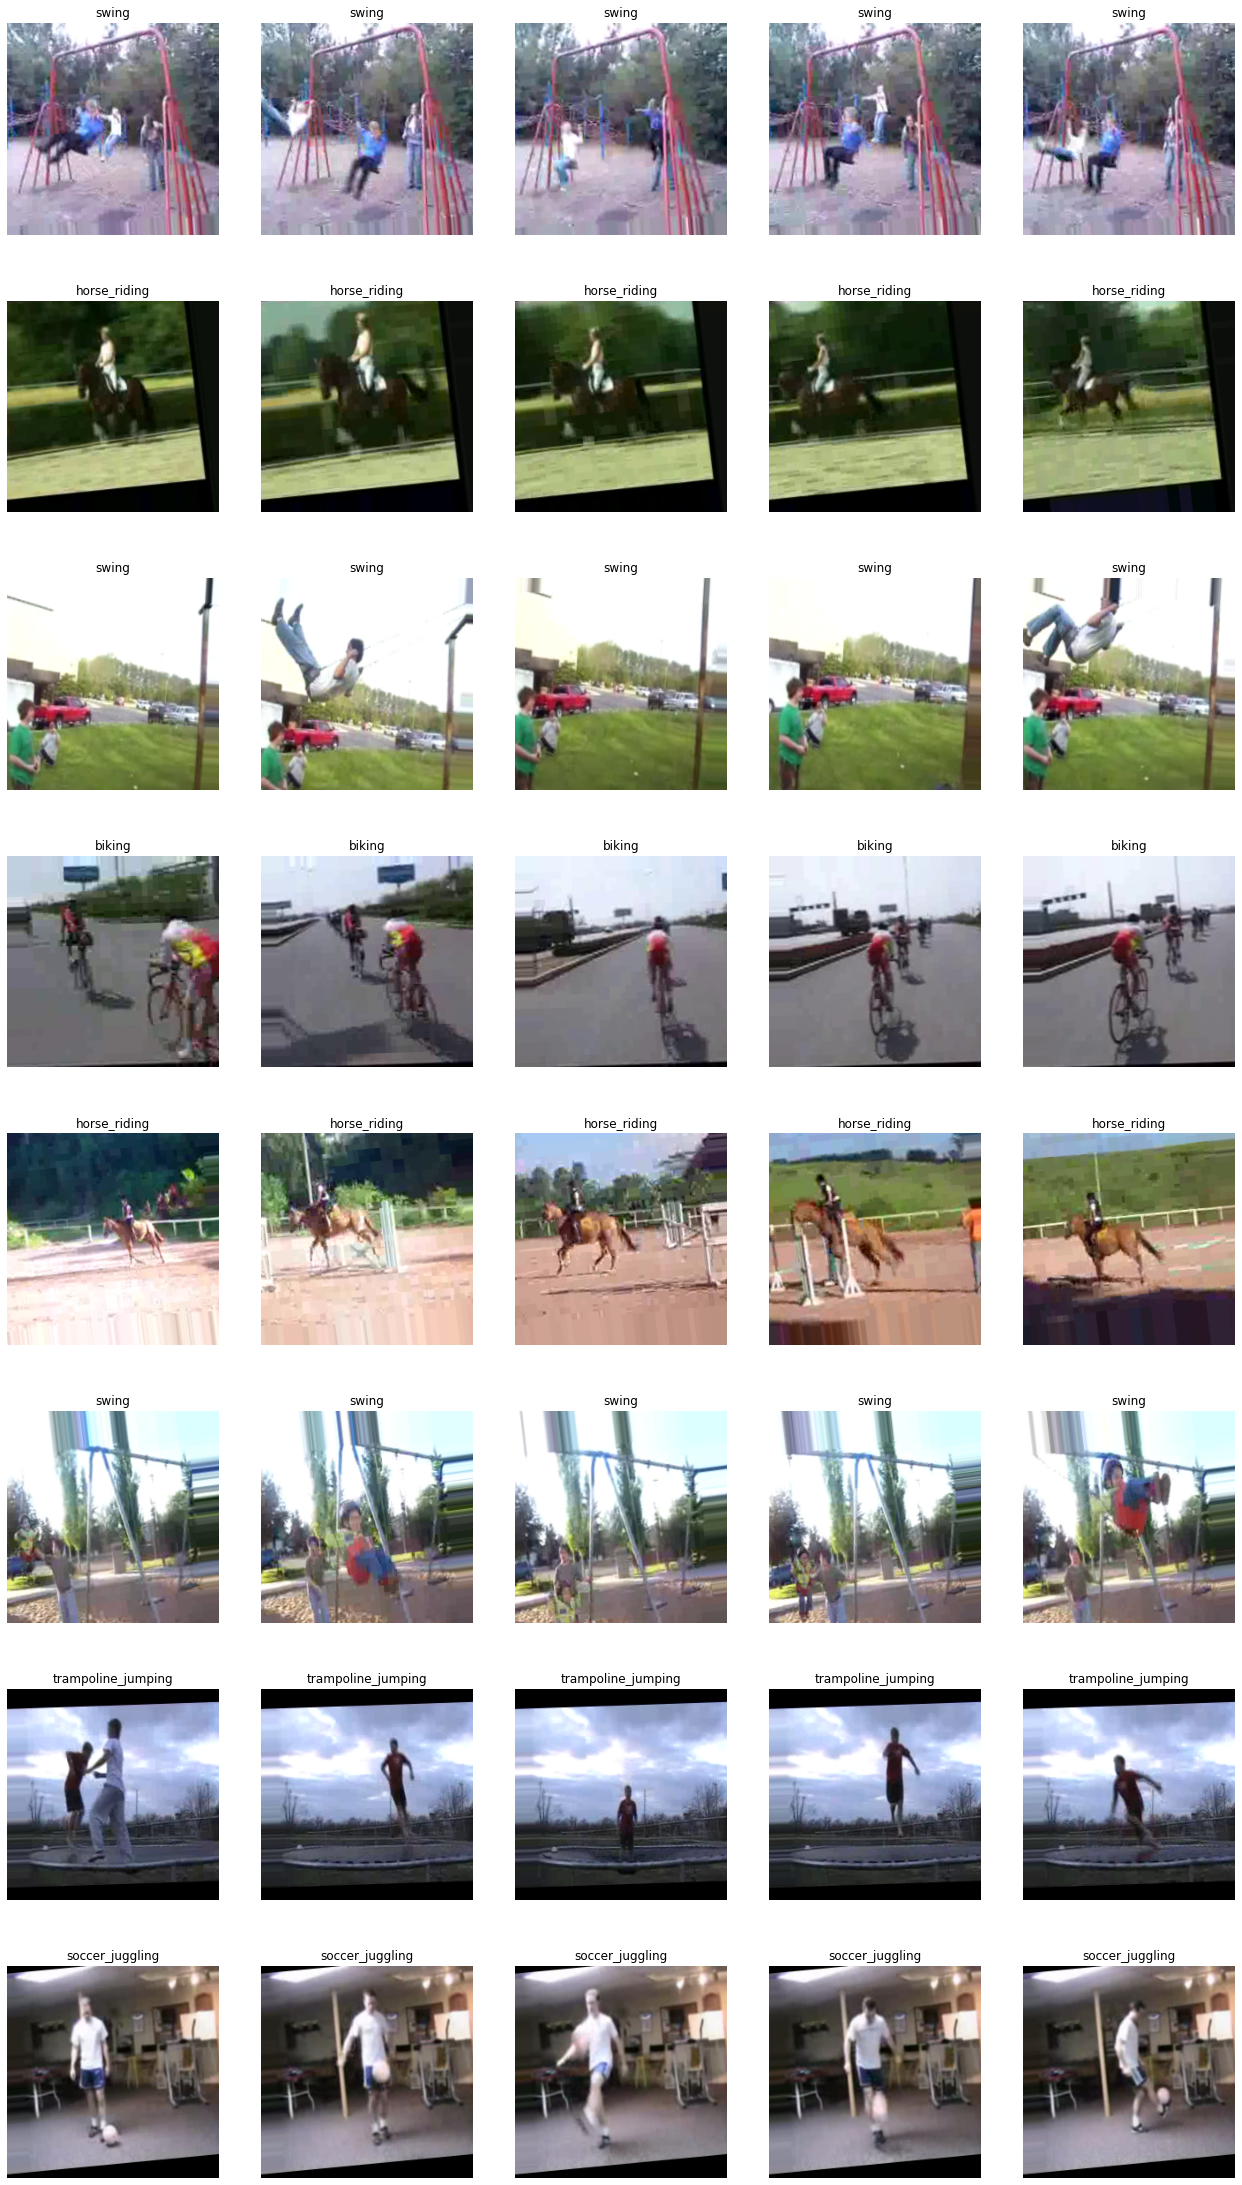

In [ ]:
import keras_video.utils
keras_video.utils.show_sample(train)

#### Importing the base Xception model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization,                                    AveragePooling2D,experimental,Input, GlobalMaxPooling2D
from tensorflow.keras.layers import Lambda, Activation, concatenate
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.applications import Xception

In [ ]:
base_model = Xception(include_top=False, weights='imagenet',\
                                         input_shape=(240,240,3), classes=len(classes))

for layer in base_model.layers:
    layer.trainable = False

##### Fine tune the last 4 layers

In [ ]:
from tensorflow.keras import layers

for layer in base_model.layers[-4:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 119, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 119, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 119, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Building the classifier

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten
model = Sequential()
# add Xception model for 5 input images (keeping the right shape
model.add(
    TimeDistributed(base_model, input_shape=(NBFRAME, 240, 240, 3))
)
# now, flatten on each output to send 5 
# outputs with one dimension to LSTM
model.add(
    TimeDistributed(
        Flatten()
    )
)
model.add(LSTM(64, activation='relu', return_sequences=False))
# finalize with standard Dense, Dropout...
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(11, activation='softmax'))

#### Defining the optimizer and Early stopping

In [ ]:
import tensorflow
opt = tensorflow.optimizers.Adam(learning_rate=0.001)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_acc', patience= 7, restore_best_weights = True)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, factor = 0.333)

In [ ]:
model.compile(opt, 'categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 8, 8, 2048)     20861480  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 131072)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33571072  
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                7

#### Train the spatial model

In [ ]:
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=30,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/30
138/138 [==============================] - 132s 904ms/step - loss: 3.6276 - acc: 0.2563 - val_loss: 0.8724 - val_acc: 0.7143
Epoch 2/30
138/138 [==============================] - 70s 510ms/step - loss: 0.9587 - acc: 0.7035 - val_loss: 0.3754 - val_acc: 0.8929
Epoch 3/30
138/138 [==============================] - 70s 506ms/step - loss: 0.6766 - acc: 0.8317 - val_loss: 0.4989 - val_acc: 0.8839
Epoch 4/30
138/138 [==============================] - 70s 507ms/step - loss: 0.7261 - acc: 0.8486 - val_loss: 0.3663 - val_acc: 0.8839
Epoch 5/30
138/138 [==============================] - 70s 506ms/step - loss: 0.3361 - acc: 0.9139 - val_loss: 0.7160 - val_acc: 0.9196
Epoch 6/30
138/138 [==============================] - 71s 513ms/step - loss: 0.2578 - acc: 0.9426 - val_loss: 0.2499 - val_acc: 0.9196
Epoch 7/30
138/138 [==============================] - 71s 510ms/step - loss: 0.3074 - acc: 0.9342 - val_loss: 0.6559 - val_acc: 0.8393
Epoch 8/30
138/138 [==============================] - 

#### Test the spatial model

In [ ]:
# pattern to get test videos and classes
glob_pattern= './DataSetV2/test/{classname}/*.mpg'

# Create video frame generator for testing
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME, 
    shuffle=False,
    batch_size=1,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=False)

Total data: 11 classes for 404 files for train


In [ ]:
model.evaluate(test)

404/404 [==============================] - 24s 58ms/step - loss: 1.2847 - acc: 0.8886


[1.2847403287887573, 0.8886138796806335]

#### Saving the spatial model

In [ ]:
model.save('Xception.h5')

#### Loading the model and getting the predictions

In [ ]:
spatial_model = tf.keras.models.load_model('../input/models/Xception (2).h5')

In [ ]:
spatial_predictions = spatial_model.predict(test)

In [ ]:
spatial_predictions.shape

(404, 11)

### Temporal Model

#### Loading the optical flow dataset from the drive

In [ ]:
!wget  --no-check-certificate -r\
 'https://docs.google.com/uc?export=download&id=1yKPyCqaWxoHkUMs-me2G-ark97svnuyU' -O 'OFDatasetV2'

In [ ]:
!unzip OFDatasetV2

In [ ]:
!wget  --no-check-certificate -r\
 'https://docs.google.com/uc?export=download&id=12CZKQAkZLIDOG1mDUSUn02s4uEzJ58oB' -O 'TestDatasetV2'

In [ ]:
!unzip TestDatasetV2

#### Getting the class names

In [ ]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = [i.split(os.path.sep)[2] for i in glob.glob('./total/*')]
classes.sort()
classes

['Basketball',
 'Biking',
 'Diving',
 'Golf_swing',
 'Horse_riding',
 'Soccer_juggling',
 'Swinging',
 'Tennis_swing',
 'Trampoline_jumping',
 'Volleyball_spiking',
 'Walking']

#### Initializing the data generator

In [ ]:
SIZE = (240, 240)
CHANNELS = 3
NBFRAME = 8
BS = 4
# pattern to get videos and classes
glob_pattern= './total/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip= False,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.1, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)
test = train.get_validation_generator()

#### Optical flow Examples

In [ ]:
keras_video.utils.show_sample(train, random= True)

In [ ]:
valid = train.get_validation_generator()

#### Making the Temporal model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization,                                    AveragePooling2D,experimental,Input, GlobalMaxPooling2D
from tensorflow.keras.layers import Lambda, Activation, concatenate, GRU
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.applications import Xception

#### Loading Xception as the base model

In [ ]:
base_model2 = Xception(include_top=False, weights='imagenet',\
                                         input_shape=(240,240,3), classes=len(classes))

for layer in base_model2.layers:
    layer.trainable = False

#### Fine tune the last 4 layers

In [ ]:
from tensorflow.keras import layers

for layer in base_model2.layers[-4:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

#### Making the classifier

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Flatten, ConvLSTM2D
Temporal_model = Sequential()
# add Xception model for 8 input images
Temporal_model.add(
    TimeDistributed(base_model2, input_shape=(NBFRAME, 240, 240, 3))
)
# now, flatten on each output to send 8
# outputs with one dimension to LSTM
Temporal_model.add(
    TimeDistributed(
        Flatten()
    )
)

Temporal_model.add(LSTM(64, activation='relu', return_sequences=False))

Temporal_model.add(Dense(11, activation='softmax'))

#### Defining the optimizer & Early stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_acc', patience= 7, restore_best_weights = True)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, factor = 0.333)

In [ ]:
import tensorflow
opt = tensorflow.optimizers.Adam(learning_rate=0.001)
Temporal_model.compile(opt, 'categorical_crossentropy', metrics=['acc'])

In [ ]:
Temporal_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 8, 8, 8, 2048)     20861480  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 131072)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33571072  
_________________________________________________________________
dense (Dense)                (None, 11)                715       
Total params: 54,433,267
Trainable params: 36,731,339
Non-trainable params: 17,701,928
_________________________________________________________________


#### Training the Temporal model

In [ ]:
Temporal_model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=30,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/30
344/344 [==============================] - 298s 847ms/step - loss: 4.1572 - acc: 0.2553 - val_loss: 2.1669 - val_acc: 0.2431
Epoch 2/30
344/344 [==============================] - 144s 419ms/step - loss: 1.9638 - acc: 0.3813 - val_loss: 2.1268 - val_acc: 0.3403
Epoch 3/30
344/344 [==============================] - 142s 414ms/step - loss: 1.6639 - acc: 0.4569 - val_loss: 1.9958 - val_acc: 0.4931
Epoch 4/30
344/344 [==============================] - 144s 418ms/step - loss: 1.5064 - acc: 0.4854 - val_loss: 1.9435 - val_acc: 0.4653
Epoch 5/30
344/344 [==============================] - 143s 415ms/step - loss: 1.4432 - acc: 0.5317 - val_loss: 1.5031 - val_acc: 0.5139
Epoch 6/30
344/344 [==============================] - 141s 409ms/step - loss: 1.4325 - acc: 0.5248 - val_loss: 1.9006 - val_acc: 0.4514
Epoch 7/30
344/344 [==============================] - 143s 414ms/step - loss: 1.2410 - acc: 0.5696 - val_loss: 2.1463 - val_acc: 0.5069
Epoch 8/30
344/344 [============================

#### Saving the Temporal model

In [ ]:
Temporal_model.save('Temporal.h5')

#### Loading the Temporal model

In [ ]:
Temporal_model = tf.keras.models.load_model('../input/models/Temporal.h5')

#### Testing the Temporal model

In [ ]:
Temporal_model.evaluate(test)

36/36 [==============================] - 4s 113ms/step - loss: 0.6812 - acc: 0.8750


[0.6812164187431335, 0.875]

#### Getting the individual predictions

In [ ]:
# pattern to get test videos and classes
glob_pattern= './Test/{classname}/*.avi'

# Create video frame generator for testing
test2 = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME, 
    shuffle=False,
    batch_size=1,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=False)

In [ ]:
temporal_predictions = Temporal_model.predict(test2)

In [ ]:
temporal_predictions

array([[4.80743229e-01, 3.85726773e-04, 4.03956685e-04, ...,
        5.13789601e-05, 2.72196368e-03, 8.07828677e-04],
       [3.42401534e-01, 2.99331676e-02, 7.77695235e-03, ...,
        5.57320483e-04, 1.27753699e-02, 1.41238542e-02],
       [9.99681711e-01, 2.32229708e-10, 1.41023804e-06, ...,
        2.90568680e-11, 3.81775135e-06, 1.00910330e-11],
       ...,
       [1.76471607e-29, 1.34464472e-25, 3.94172761e-32, ...,
        1.99176664e-15, 5.67613543e-38, 1.00000000e+00],
       [1.21347667e-19, 3.70153742e-16, 2.03098472e-24, ...,
        1.24026860e-13, 1.22663215e-29, 9.99907136e-01],
       [6.23190317e-06, 5.42708858e-06, 1.06024272e-04, ...,
        3.88171103e-13, 6.10812140e-06, 9.98423457e-01]], dtype=float32)

In [ ]:
spatial_predictions

array([[1.0000000e+00, 1.8215043e-15, 5.6370460e-12, ..., 3.0384483e-23,
        2.6508462e-10, 1.3435455e-13],
       [1.0000000e+00, 2.4319168e-22, 2.1027198e-17, ..., 1.1573885e-33,
        3.3894665e-15, 3.9174828e-20],
       [1.0000000e+00, 7.7160488e-19, 6.2468006e-15, ..., 2.0086696e-28,
        8.6612938e-13, 6.3688103e-17],
       ...,
       [2.2566496e-22, 5.6338934e-13, 0.0000000e+00, ..., 3.2836018e-32,
        2.5643345e-17, 1.0000000e+00],
       [2.6396094e-07, 2.9818986e-03, 3.2227634e-10, ..., 3.4555941e-07,
        1.1092714e-06, 9.1403049e-01],
       [2.5529419e-03, 3.8098465e-03, 1.5537664e-05, ..., 4.2635409e-04,
        4.2982670e-03, 9.3581957e-01]], dtype=float32)

### Two Stream Network

#### Fuse the predictions & Take the Average

In [ ]:
Average_fusion = np.add(spatial_predictions, temporal_predictions)

#### Testing the Two Stream performance

In [ ]:
number_per_class_list = [41, 43, 36, 41, 58, 39, 29, 35, 35, 20, 27]

right_predictions = 0
Total_samples = np.sum(number_per_class_list)
counter = 0

for i in range(len(classes)):
    for j in range(number_per_class_list[i]):
        if i == 0:
            pred = np.argmax(Average_fusion[j])
        else:
            pred = np.argmax(Average_fusion[counter + j])
        
        if pred == i:
            right_predictions += 1 
    counter += number_per_class_list[i]
accuracy = right_predictions/ Total_samples

In [ ]:
accuracy

0.9529702970297029